<a href="https://colab.research.google.com/github/SantiagoBuffa/BeatAI/blob/main/VectorFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from google.colab import userdata
import os, json
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow


In [51]:
!git clone https://github.com/SantiagoBuffa/BeatAI.git
%cd BeatAI

Cloning into 'BeatAI'...
remote: Enumerating objects: 1042, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1042 (delta 11), reused 22 (delta 9), pack-reused 1010 (from 1)
Receiving objects: 100% (1042/1042), 103.56 MiB | 28.31 MiB/s, done.
Resolving deltas: 100% (690/690), done.
/content/BeatAI


In [52]:


kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip install kaggle --quiet
!kaggle datasets download -d evilspirit05/ecg-analysis -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/evilspirit05/ecg-analysis
License(s): MIT
100% 826M/826M [00:04<00:00, 224MB/s]
100% 826M/826M [00:04<00:00, 201MB/s]


In [53]:
def load_image_rgb(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"No se pudo abrir {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [54]:
def binarize_and_clean(roi_gray):
    # Contraste local
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(roi_gray)
    # Blur ligero
    blurred = cv2.GaussianBlur(enhanced, (5,5), 0)
    # Umbral adaptativo invertido (la señal queda blanca en bin_img)
    bin_img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 31, 9)
    # Cerrar pequeñas discontinuidades de la señal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=1)
    return bin_img

In [125]:
def extract_ecg_roi(img_rgb, min_area=10000):

    #Extrae el contorno de la cuadrícula (rojo/rosa)

    # 1. Convertir a HSV
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # 2. Definir rangos para la cuadrícula (rojo/rosa)
    lower_red1 = np.array([0, 50, 100])
    upper_red1 = np.array([15, 255, 255])
    lower_red2 = np.array([160, 50, 100])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    grid_mask = mask1 + mask2

    # Cerrar huecos en la cuadrícula para obtener un solo contorno
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    grid_mask = cv2.morphologyEx(grid_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Encontrar contornos en la máscara de la cuadrícula
    contours, _ = cv2.findContours(grid_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        # Fallback si no se detecta la cuadrícula
        h, w = img_rgb.shape[:2]
        return img_rgb # Devuelve la imagen completa

    #Encontrar el contorno más grande (que debe ser la cuadrícula)
    big = max(contours, key=cv2.contourArea)

    # Obtener el bounding box de ESE contorno
    x,y,w,h = cv2.boundingRect(big)

    # 7. Recortar la imagen RGB original a ese bounding box
    roi = img_rgb[y:y+h, x:x+w]
    return roi

In [128]:
def kmeans_1d_weighted(indices, weights, k=4, max_iter=100, tol=1e-3):
    # Inicializar centros equiespaciados
    idx_min, idx_max = indices.min(), indices.max()
    centers = np.linspace(idx_min, idx_max, k)
    for it in range(max_iter):
        # Asignar cada index al centro más cercano
        dists = np.abs(indices.reshape(-1,1) - centers.reshape(1,-1))
        labels = dists.argmin(axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            mask = labels == j
            if not np.any(mask):
                new_centers[j] = centers[j]
            else:
                # media ponderada por weights
                w = weights[mask]
                idxs = indices[mask]
                new_centers[j] = np.sum(idxs * w) / (np.sum(w) + 1e-9)
        shift = np.max(np.abs(new_centers - centers))
        centers = new_centers
        if shift < tol:
            break
    return np.sort(centers)

In [127]:
def split_roi_by_peak_centers(roi_rgb, num_parts=4):
    gray = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2GRAY)
    bin_img = binarize_and_clean(gray)  # señal en blanco sobre negro
    # proyección horizontal: cantidad de píxeles ON por fila
    proj = bin_img.sum(axis=1).astype(float)
    if proj.max() == 0:
        # si no hay nada, caemos al split uniforme
        h = roi_rgb.shape[0]
        q = h // num_parts
        parts = [roi_rgb[i*q:(i+1)*q if i < num_parts-1 else h, :] for i in range(num_parts)]
        return parts, bin_img, proj

    # filas y pesos (normalizar pesos)
    rows = np.arange(len(proj))
    weights = proj / (proj.max() + 1e-9)

    # obtener k centros
    centers = kmeans_1d_weighted(rows, weights, k=num_parts)

    # definir límites como puntos medios entre centros
    centers = np.array(centers)
    cuts = []
    for i in range(len(centers)-1):
        cuts.append(int(round((centers[i] + centers[i+1]) / 2.0)))
    # construir partes: desde 0 a cuts[0], cuts[0] a cuts[1] ...
    parts = []
    start = 0
    for c in cuts:
        parts.append(roi_rgb[start:c, :])
        start = c
    parts.append(roi_rgb[start:roi_rgb.shape[0], :])

    # Asegurar que tenemos exactamente num_parts (si hay partes vacías ajustar)
    # Si alguna parte está vacía (altura 0), repartir uniformemente
    for p in parts:
        if p.shape[0] == 0:
            h = roi_rgb.shape[0]
            q = h // num_parts
            parts = [roi_rgb[i*q:(i+1)*q if i < num_parts-1 else h, :] for i in range(num_parts)]
            break

    return parts

In [129]:
def part_to_raw_vector(part_rgb):
    """
    Vectoriza la parte eliminando la cuadrícula (color) Y el texto (ruido).
    """
    h, w, _ = part_rgb.shape
    if h == 0 or w == 0:
        return np.array([], dtype=float)

    #Convertir a HSV
    hsv = cv2.cvtColor(part_rgb, cv2.COLOR_RGB2HSV)

    #Definir rangos para la cuadrícula (rojo/rosa)
    lower_red1 = np.array([0, 50, 100])
    upper_red1 = np.array([15, 255, 255])
    lower_red2 = np.array([160, 50, 100])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    grid_mask_hsv = mask1 + mask2

    #Dilatar la máscara para que cubra bien
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    grid_mask_hsv = cv2.dilate(grid_mask_hsv, kernel, iterations=1)

    #Convertir la parte a escala de grises
    gray = cv2.cvtColor(part_rgb, cv2.COLOR_RGB2GRAY)

    #Borrar la cuadrícula: Poner en blanco (255)
    gray[grid_mask_hsv == 255] = 255

    #Binarizar la señal (tiene señal + texto)
    _, signal_bin = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # ELIMINAR EL TEXTO (RUIDO)
    # Un 'OPEN' morfológico elimina objetos pequeños (texto)
    noise_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    signal_bin_cleaned = cv2.morphologyEx(signal_bin, cv2.MORPH_OPEN, noise_kernel, iterations=1)

    #Vectorizar (usando la imagen LIMPIA y MEDIANA)
    cols = signal_bin_cleaned.shape[1]
    ys = np.zeros(cols, dtype=float)

    for col in range(cols):
        rows_on = np.where(signal_bin_cleaned[:, col] == 255)[0]
        if rows_on.size > 0:
            ys[col] = np.median(rows_on)
        else:
            ys[col] = np.nan

    #Interpolar NaNs
    nans = np.isnan(ys)
    if nans.all():
        ys[:] = h / 2.0
    elif nans.any():
        not_nan = ~nans
        x_indices = np.arange(cols)
        ys[nans] = np.interp(x_indices[nans], x_indices[not_nan], ys[not_nan])

    # Invertir vector (para que "picos" sean positivos)
    if not nans.all():
        ys = (h - 1) - ys

    return ys

In [130]:
def resize_vector(v, target_len):
    if len(v) == target_len:
        return v.copy()
    x_old = np.linspace(0, 1, len(v))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, v).astype(np.float32)


In [131]:
def ecg_image_to_vector_fixed(path, target_len=2048, normalize_global=True, smooth=True, num_parts=4):
    img = load_image_rgb(path)
    roi = extract_ecg_roi(img)  # roi RGB
    parts = split_roi_by_peak_centers(roi, num_parts=num_parts)

    # obtener vectores crudos (sin normalizar)
    raw_vecs = [part_to_raw_vector(p) for p in parts]
    # Concatenar
    full_raw = np.concatenate(raw_vecs)

    # Normalización global opcional
    if normalize_global:
        mn, mx = np.nanmin(full_raw), np.nanmax(full_raw)
        if mx - mn > 1e-6:
            full = (full_raw - mn) / (mx - mn)
        else:
            full = np.zeros_like(full_raw)
    else:
        full = full_raw.copy()

    # Suavizado global opcional (gaussiano 1D)
    if smooth:
        full = cv2.GaussianBlur(full.reshape(-1,1),(9,1),0).flatten()

    # Redimensionar a target_len
    final = resize_vector(full, target_len)

    return final, parts, roi

In [133]:
def ecg_to_vector(image_path, target_len=2048):
    import numpy as np
    import cv2

    img = load_image_rgb(image_path)
    roi = extract_ecg_roi(img)
    parts = split_roi_by_peak_centers(roi, num_parts=4)

    centered_vectors = [] # <-- Lista para vectores centrados

    for i, p in enumerate(parts):
        # 1. Usar la función de vectorización (idealmente la mejorada)
        vec = part_to_raw_vector(p)
        if vec.size == 0:
            continue

        baseline = np.nanmedian(vec)
        if not np.isnan(baseline):
            vec_centered = vec - baseline
        else:
            vec_centered = vec # Dejarlo como está si todo es NaN

        centered_vectors.append(vec_centered)

    # 3. Concatenar los vectores ya centrados
    if not centered_vectors:
        return np.zeros(target_len, dtype=float) # Fallback

    full = np.concatenate(centered_vectors)

    mn, mx = np.nanmin(full), np.nanmax(full)
    if mx - mn > 1e-6:
        # Normalizamos a [-1, 1] o [0, 1]
        # [0, 1] está bien:
        full = (full - mn) / (mx - mn)
    else:
        full = np.full_like(full, 0.5) # Todo plano, poner en el medio

    # 5. Suavizado
    full = cv2.GaussianBlur(full.reshape(-1,1),(9,1),0).flatten()

    # 6. Resize final
    full = resize_vector(full, target_len)

    return full

In [134]:
def show_parts_and_vector_colab(path):
    final, parts, roi= ecg_image_to_vector_fixed(path, target_len=2048)

    # Mostrar ROI y partes con cv2_imshow en Colab
    print("ROI detectado:")
    cv2_imshow(cv2.cvtColor(roi, cv2.COLOR_RGB2BGR))  # cv2_imshow espera BGR internamente

    for i,p in enumerate(parts):
        print(f"Parte {i+1} shape: {p.shape}")
        cv2_imshow(cv2.cvtColor(p, cv2.COLOR_RGB2BGR))


    # Mostrar vector final
    plt.figure(figsize=(30,3))
    plt.plot(final)
    plt.title("Vector final corregido")
    plt.grid(True)
    plt.show()

    return final, parts, roi

ROI detectado:


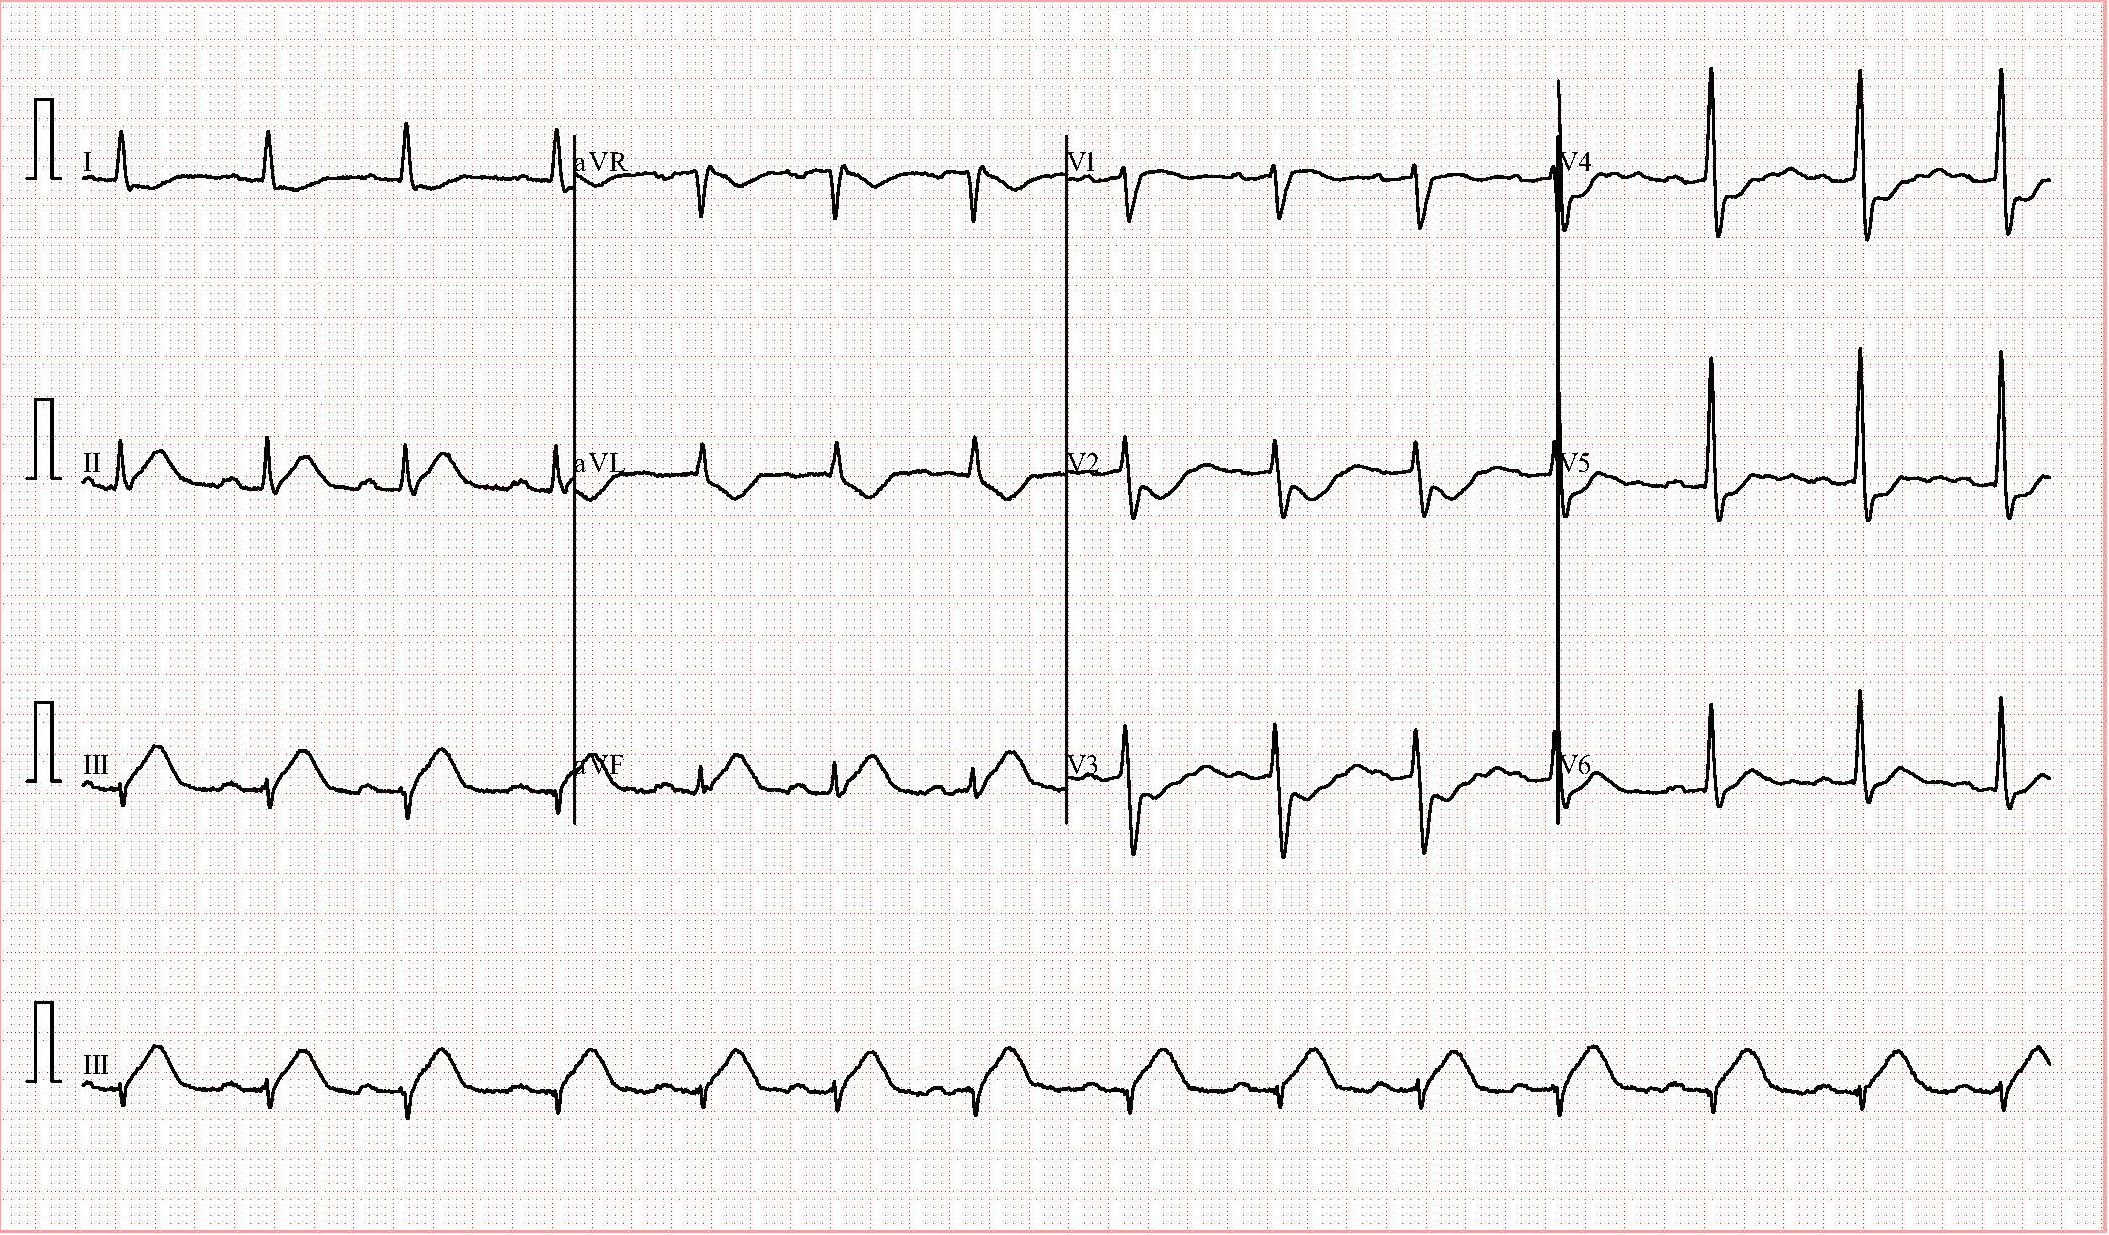

Parte 1 shape: (306, 2109, 3)


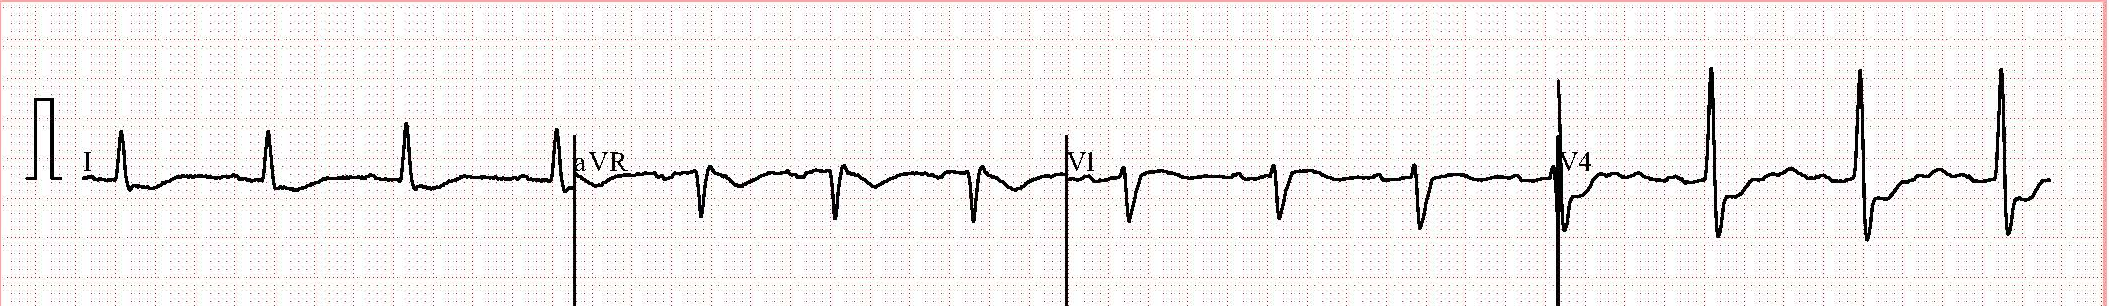

Parte 2 shape: (308, 2109, 3)


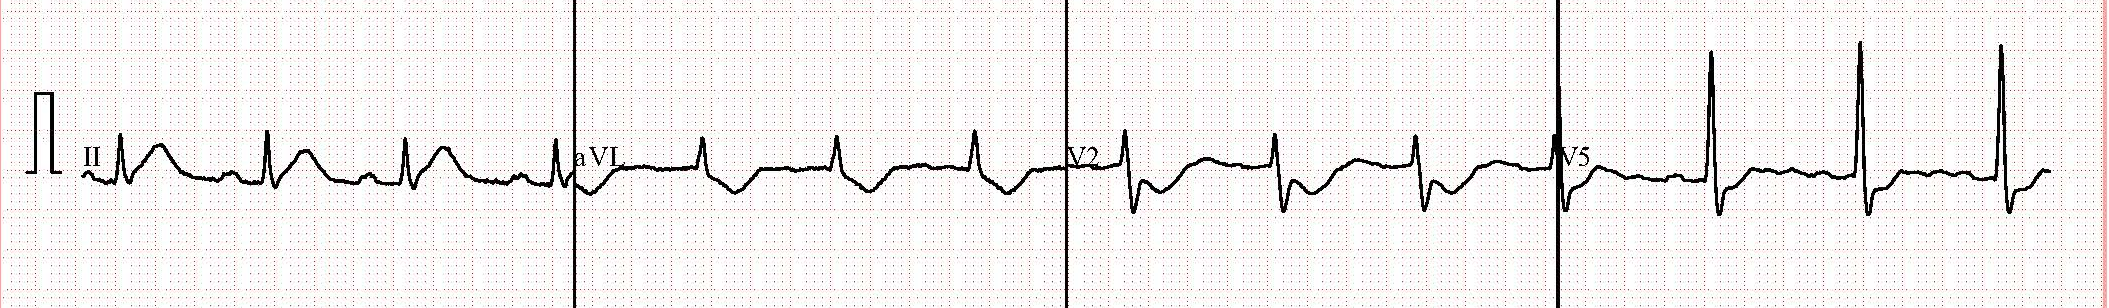

Parte 3 shape: (313, 2109, 3)


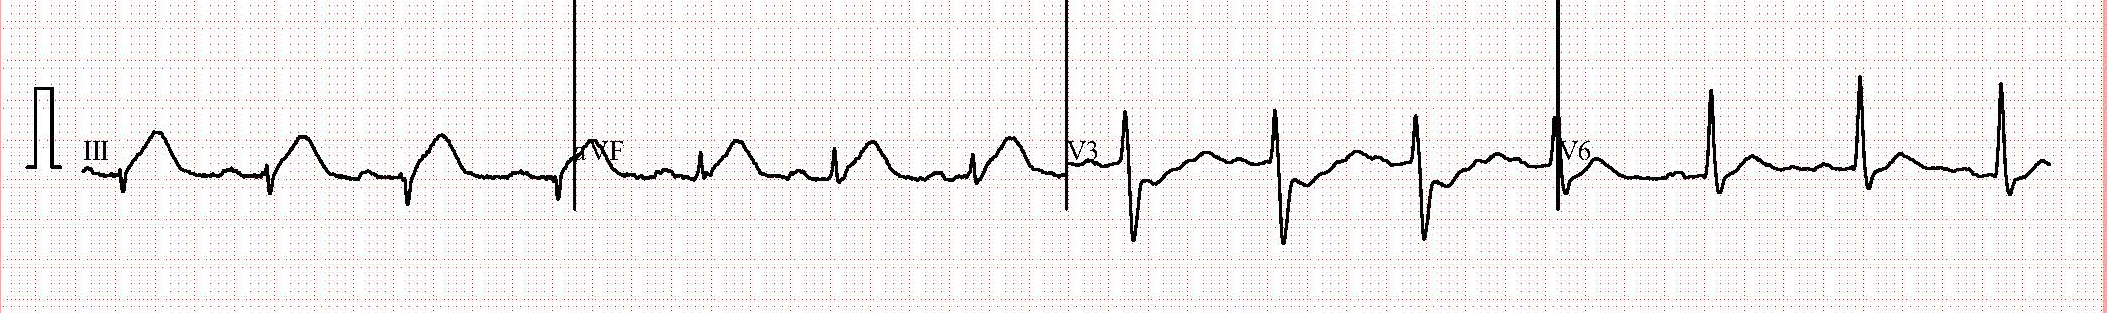

Parte 4 shape: (308, 2109, 3)


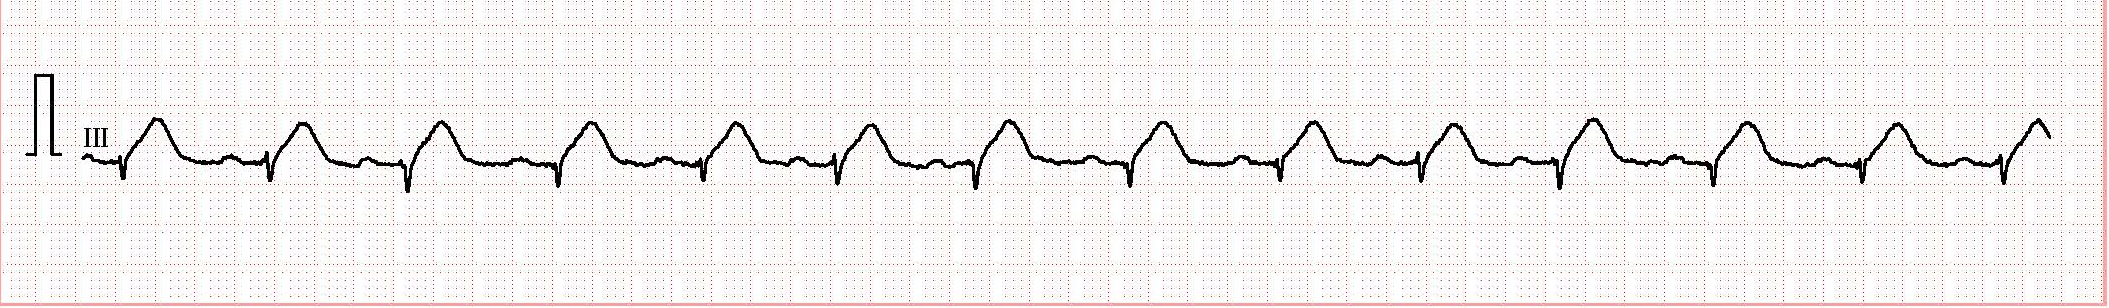

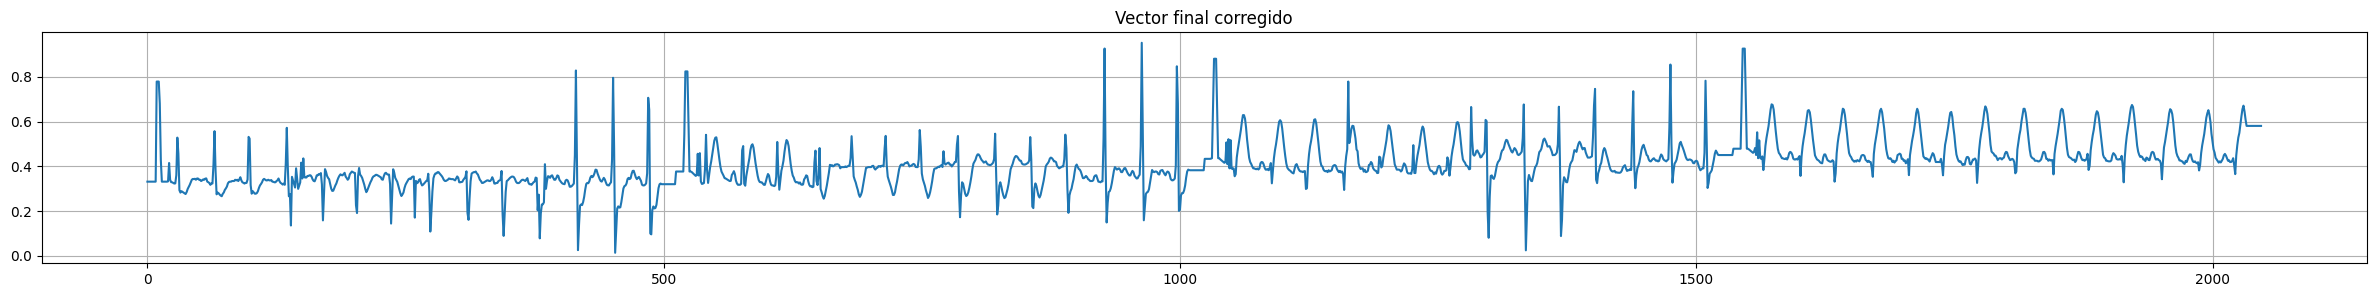

In [135]:
show_parts_and_vector_colab("/content/MI(1).jpg");

In [136]:
def preprocess_dataset_1d(dataset_path, target_len=2048, num_rows=4):

    #Carga todas las imágenes del dataset y genera vectores 1D concatenados.

    train_dir = os.path.join(dataset_path, 'train')
    test_dir = os.path.join(dataset_path, 'test')

    X_train, y_train = [], []
    X_test, y_test = [], []

    class_names = sorted(os.listdir(train_dir))
    print(f"📂 Clases detectadas: {class_names}")

    # --- TRAIN ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(train_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (train)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            vec = ecg_to_vector(path, target_len)

            X_train.append(vec)
            y_train.append(label)

    # --- TEST ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(test_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (test)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            vec = ecg_to_vector(path, target_len)

            if vec is None:
                continue
            X_test.append(vec)
            y_test.append(label)

    X_train = np.array(X_train)[..., np.newaxis]
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    X_test = np.array(X_test)[..., np.newaxis]
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

    # --- VALIDATION ---
    # X_val se creará a partir de X_train.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train.argmax(axis=1)
    )

    print(f"✅ X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [144]:
def build_ecg_1d_model(input_length=2048, num_classes=4):

    #Construye el modelo CNN 1D
    model = models.Sequential([
        layers.Input(shape=(input_length,)),
        # Reshape para añadir el canal (necesario para Conv1D)
        layers.Reshape((input_length, 1)),

        layers.Conv1D(64, 20, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(128, 10, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(256, 5, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [66]:
dataset_path = "/content/BeatAI/data/ECG_DATA"
TARGET_VECTOR_LENGTH = 2048
NUM_CLASSES = 4


X_train, y_train, X_val, y_val, X_test, y_test = preprocess_dataset_1d(
    dataset_path
)




📂 Clases detectadas: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (train): 100%|██████████| 956/956 [04:48<00:00,  3.32it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (train): 100%|██████████| 516/516 [02:28<00:00,  3.48it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (train): 100%|██████████| 699/699 [03:40<00:00,  3.17it/s]
Procesando Normal Person ECG Images (284x12=3408) (train): 100%|██████████| 852/852 [04:04<00:00,  3.48it/s]
Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (test): 100%|██████████| 239/239 [01:07<00:00,  3.52it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (test): 100%|██████████| 172/172 [00:48<00:00,  3.51it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (test): 100%|██████████| 233/233 [01:06<00:00,  3.48it/s]
Procesando Normal Person ECG Images (284x12=3408) (test): 100%|██████████| 284/284 [01:20<00:00,  3.51it/s

✅ X_train: (2418, 2048, 1), X_val: (605, 2048, 1), X_test: (928, 2048, 1)


In [145]:
# Construir el modelo
model = build_ecg_1d_model(
    input_length=TARGET_VECTOR_LENGTH,
    num_classes=NUM_CLASSES
)



In [146]:
model.summary()

print("\nIniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)]
)

# Evaluar en el conjunto de test (limpio)
print("\nEvaluando en el conjunto de test (limpio)...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_6 (Reshape)             │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 2048, 64)       │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 1024, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 512, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,900 (1.07 MB)

 Trainable params: 280,900 (1.07 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.2854 - loss: 1.3662 - val_accuracy: 0.3157 - val_loss: 1.5446
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3547 - loss: 1.3094 - val_accuracy: 0.4645 - val_loss: 1.1768
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4495 - loss: 1.1464 - val_accuracy: 0.4463 - val_loss: 1.1496
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5115 - loss: 1.0540 - val_accuracy: 0.5653 - val_loss: 1.0168
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5194 - loss: 1.0342 - val_accuracy: 0.5471 - val_loss: 0.9746
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5687 - loss: 0.9724 - val_accuracy: 0.5653 - val_loss: 0.9528
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6028 - loss: 0.9231 - val_accuracy: 0.6050 - val_loss: 0.8899
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6413 - los

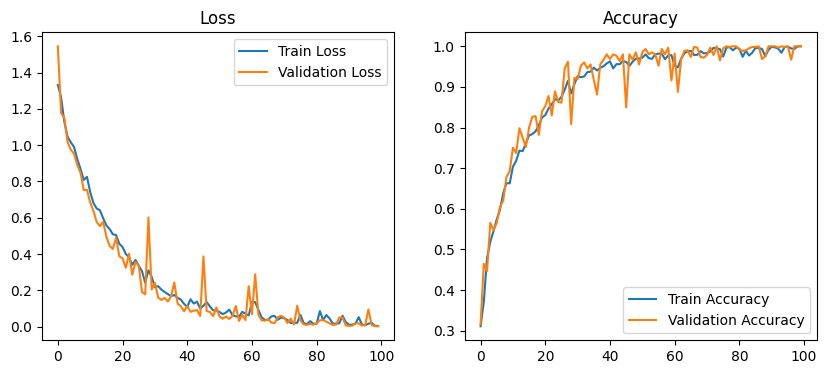

In [147]:
def show_graphs(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

show_graphs(history)

In [70]:
model.save("models/ecg_modelVectorFinal.h5")

In [71]:
#!git push origin main